Comparing merge-tests on Salish and Japser. A week long run to see how the differences evolve. 

In [1]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as NC
import numpy as np
import scipy.interpolate as sp
import math

import datetime

from salishsea_tools import stormtools, nc_tools

In [2]:
#load up the bathymetry. 
grid = NC.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc','r')
bathy = grid.variables['Bathymetry'][:,:]
X = grid.variables['nav_lon'][:,:]
Y = grid.variables['nav_lat'][:,:]

In [3]:
#load in the datas. Trying something new with dict objects...

#first run (3.4)
r1 = 'initial';
runname1 = '/data/nsoontie/MEOPAR/SalishSea/results/merge-tests/merg2015/' + r1 
print runname1

#second run (3.6)
r2 = 'three-six'
runname2 = '/ocean/sallen/allen/research/MEOPAR/nemo-3.6-code/NEMOGCM/CONFIG/SalishSea/EXP00'
print runname2

runs = {r1: runname1, r2: runname2}


/data/nsoontie/MEOPAR/SalishSea/results/merge-tests/merg2015/initial
/ocean/sallen/allen/research/MEOPAR/nemo-3.6-code/NEMOGCM/CONFIG/SalishSea/EXP00


In [4]:
fUs={}; fVs={}; fTs={}
for key, path in runs.iteritems():
    fUs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121215_grid_U.nc','r');
    fVs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121215_grid_V.nc','r');
    fTs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121215_grid_T.nc','r');

Show info about the files

In [5]:
for key in runs:
    print key
    nc_tools.show_dataset_attrs(fUs[key])

initial
file format: NETCDF4
Conventions: CF-1.1
production: An IPSL model
TimeStamp: 28/05/2015 14:51:46 -0700
file_name: SalishSea_1h_20121214_20121215_grid_U.nc
history: Thu May 28 14:54:57 2015: ncks -4 -L4 -O SalishSea_1h_20121214_20121215_grid_U.nc SalishSea_1h_20121214_20121215_grid_U.nc
NCO: 4.4.2
three-six
file format: NETCDF4
name: SalishSea_1h_20121214_20121215
description: ocean U grid variables
conventions: CF-1.1
production: An IPSL model
timeStamp: 2015-May-23 16:36:29 PDT


In [6]:
for key in runs:
    print key
    nc_tools.show_variable_attrs(fUs[key])

initial
<type 'netCDF4.Variable'>
float32 depthu(depthu)
    axis: Z
    standard_name: model_level_number
    units: m
    positive: down
    valid_min: 0.5
    valid_max: 441.466
    title: depthu
    long_name: Vertical U levels
unlimited dimensions: 
current shape = (40,)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4.Variable'>
float32 nav_lat(y, x)
    standard_name: latitude
    units: degrees_north
    valid_min: 46.8606
    valid_max: 51.1056
    long_name: Latitude
    nav_model: Default grid
unlimited dimensions: 
current shape = (898, 398)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4.Variable'>
float32 nav_lon(y, x)
    standard_name: longitude
    units: degrees_east
    valid_min: -126.397
    valid_max: -121.316
    long_name: Longitude
    nav_model: Default grid
unlimited dimensions: 
current shape = (898, 398)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4.Variable'>
float64 time_counter(t

Different sizes because initial is 48 hours. 

In [7]:
t=1
depthlevel=0

#U,V,SSH,Salinity,Temperature
Us={}; Vs={}; Es={}; Ss={}; Ts={}
tims = {}
t_orig = {}
tim_count={}

for key in runs:
    [Us[key], Vs[key], Es[key], Ss[key], Ts[key]] = stormtools.get_variables(fUs[key],fVs[key],fTs[key],
                                                                                     t,depthlevel)
    tim_count[key] = fUs[key].variables['time_counter']
    tims[key] =tim_count[key][t]
t_orig['initial'] = datetime.datetime.strptime(
                    tim_count['initial'].time_origin.title(), ' %Y-%b-%d %H:%M:%S')
t_orig['three-six'] = datetime.datetime.strptime(
                tim_count['three-six'].time_origin.title(), '%Y-%m-%d %H:%M:%S')


In [8]:
def plot_variables(t,figsize=(10,5)):
    #get data
    
    #U,V,SSH,Salinity,Temperature
    Us={}; Vs={}; Es={}; Ss={}; Ts={}
    tims = {}
    tim_count={}

    for key in runs:
        [Us[key], Vs[key], Es[key], Ss[key], Ts[key]] = stormtools.get_variables(fUs[key],fVs[key],fTs[key],
                                                                                     t,depthlevel)
        tim_count[key] = fUs[key].variables['time_counter']
        tims[key] =tim_count[key][t]
    #U
    fig, axs=plt.subplots(1,2,figsize=figsize)
    umin=-3; umax=3
    for key,ax in zip(runs,axs):
        out= t_orig[key] + datetime.timedelta(t,tims[key])
        mesh=ax.pcolormesh(Us[key],vmin=umin,vmax=umax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label('U [m/s]')
    #V    
    fig, axs=plt.subplots(1,2,figsize=figsize)
    for key,ax in zip(runs,axs):
        out= t_orig[key] + datetime.timedelta(t,tims[key])
        mesh=ax.pcolormesh(Vs[key],vmin=umin,vmax=umax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label('V [m/s]')
    #SSH    
    fig, axs=plt.subplots(1,2,figsize=figsize)
    emin=-3; emax=3
    for key,ax in zip(runs,axs):
        out= t_orig[key] + datetime.timedelta(t,tims[key])
        mesh=ax.pcolormesh(Es[key],vmin=emin,vmax=emax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label('SSH [m]')
    #Sal    
    fig, axs=plt.subplots(1,2,figsize=figsize)
    smin=0; smax=34
    for key,ax in zip(runs,axs):
        out= t_orig[key] + datetime.timedelta(t,tims[key])
        mesh=ax.pcolormesh(Ss[key],vmin=smin,vmax=smax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label('Salinity [psu]')

Initial

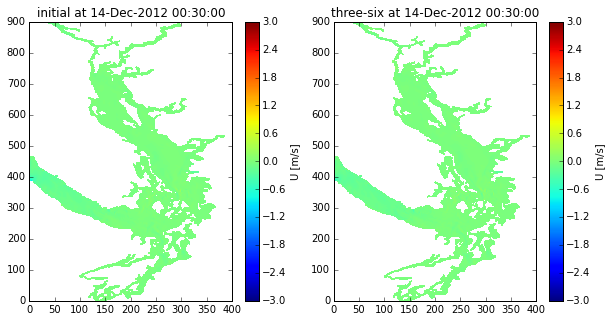

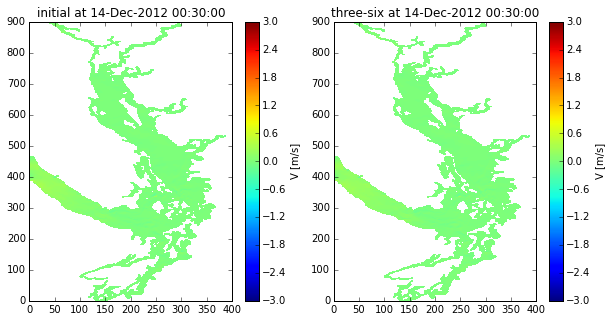

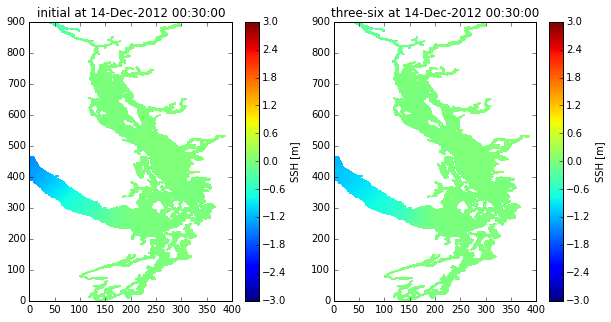

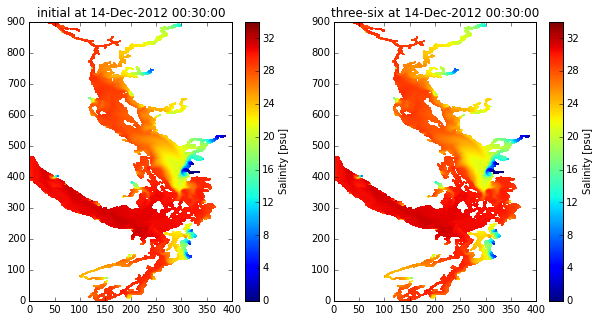

In [9]:
plot_variables(0)


One hour

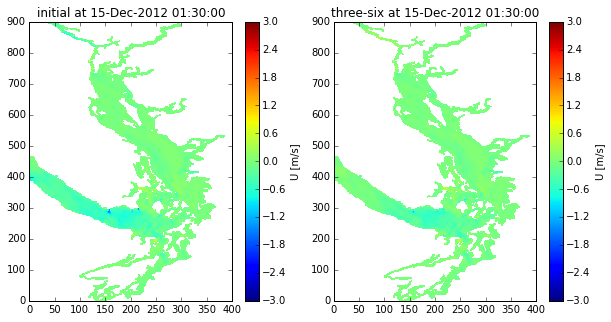

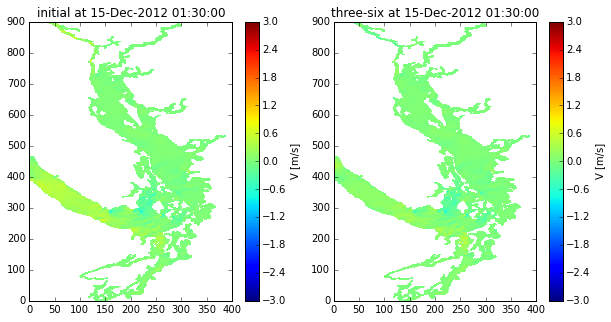

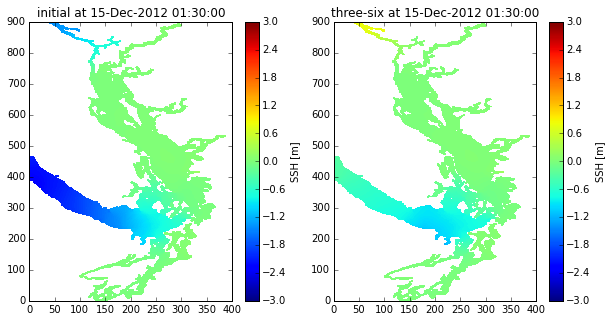

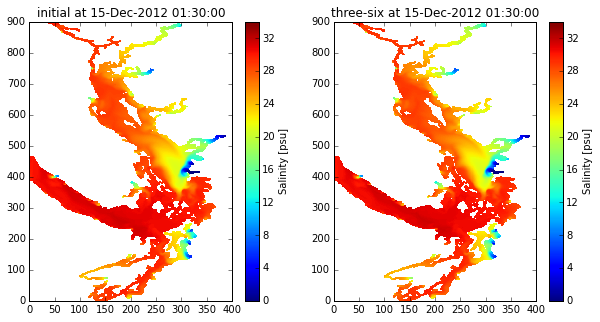

In [10]:
plot_variables(1)

Looks like we are at different times in the tidal cylce. Why? Output times match up...


Has the frequency of the tidal constituents changed? Perhaps written in different units?


Now look at Juan de Fuca ssh over time

In [11]:
sshs={}
i=1
j=450

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    

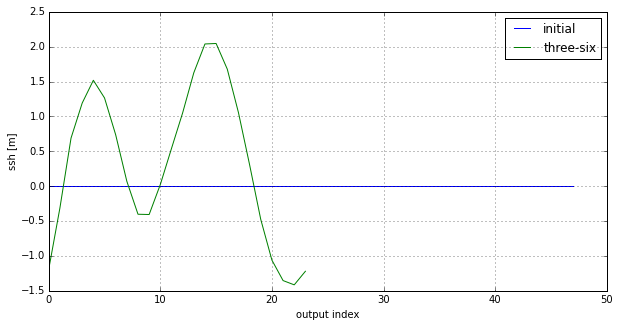

In [12]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
for key in runs:
    ax.plot(sshs[key],label=key)

ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

Why is second index zero in initial but not three-six.

Next to boundary

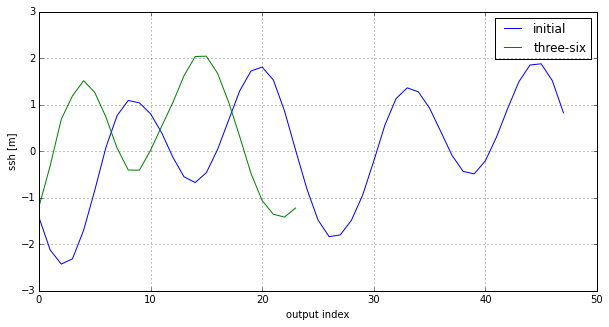

In [13]:
sshs={}
i=2
j=450

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))
for key in runs:
    ax.plot(sshs[key],label=key)

ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

North

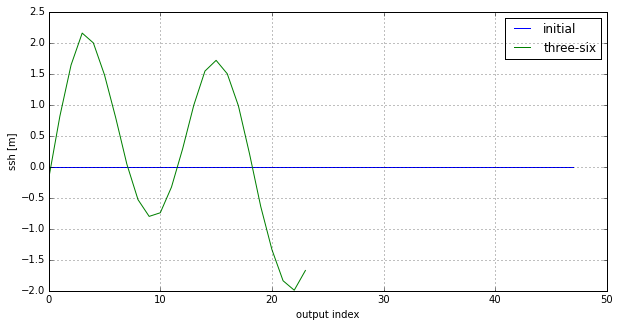

In [14]:
sshs={}
i=50
j=896

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))
for key in runs:
    ax.plot(sshs[key],label=key)

ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

Same here. At the north, initial has two points on the T grid that are zero...

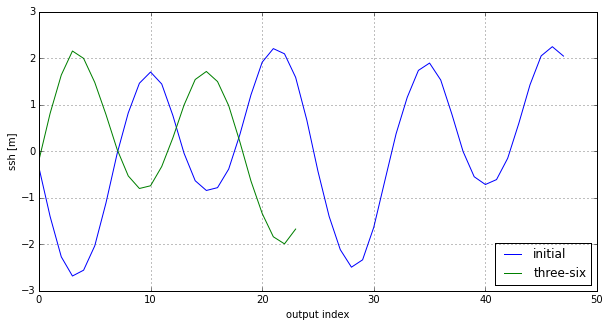

In [15]:
sshs={}
i=50
j=895

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))
for key in runs:
    ax.plot(sshs[key],label=key)

ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

Again, phases off and max/mins don't align